# Clasificación de Residuos con Redes Neuronales Convolucionales (CNN) y Transfer Learning

Este notebook presenta el desarrollo de un sistema de clasificación de imágenes para diferentes tipos de residuos, utilizando Redes Neuronales Convolucionales (CNNs) y la técnica de Transfer Learning con el modelo VGG16. El objetivo es identificar categorías como cartón, vidrio, metal, papel, plástico y basura general para mejorar la gestión de residuos.

In [44]:
# ============================================
# PARTE 1: DESCARGA Y PREPARACIÓN DEL DATASET
# ============================================

# Librerías
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [ ]:
# ============================================
# DESCARGA DEL DATASET DESDE KAGGLEHUB
# ============================================

import kagglehub
import os

try:
    # Descargar el dataset
    path = kagglehub.dataset_download("feyzazkefe/trashnet")
    print(f" Dataset descargado correctamente en:\n{path}")

    # Verificar estructura
    print("\n Contenido del dataset:")
    for root, dirs, files in os.walk(path):
        level = root.replace(path, '').count(os.sep)
        indent = ' ' * 4 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print(f"{subindent}{f}")
except Exception as e:
    print(f" Error al descargar el dataset: {e}")


Using Colab cache for faster access to the 'trashnet' dataset.
 Dataset descargado correctamente en:
/kaggle/input/trashnet

 Contenido del dataset:
trashnet/
    dataset-resized/
        metal/
            metal375.jpg
            metal341.jpg
            metal374.jpg
            metal383.jpg
            metal215.jpg
            metal113.jpg
            metal213.jpg
            metal226.jpg
            metal147.jpg
            metal90.jpg
            metal130.jpg
            metal63.jpg
            metal149.jpg
            metal344.jpg
            metal8.jpg
            metal68.jpg
            metal323.jpg
            metal129.jpg
            metal37.jpg
            metal7.jpg
            metal6.jpg
            metal145.jpg
            metal405.jpg
            metal140.jpg
            metal114.jpg
            metal182.jpg
            metal263.jpg
            metal366.jpg
            metal154.jpg
            metal208.jpg
            metal315.jpg
            metal355.jpg
            met

In [ ]:
# ============================================
# PARTE 2: CREACIÓN DE GENERADORES DE IMÁGENES
# ============================================

# Directorios de entrenamiento y validación (usaremos split 80/20)
# Definir el directorio base del dataset descargado por kagglehub
import os

base_dir = "/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized"

if not os.path.exists(base_dir):
    print(f"Error: El directorio base '{base_dir}' no existe. Por favor, verifica la ruta.")
else:
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        validation_split=0.2
    )

    train_generator = train_datagen.flow_from_directory(
        base_dir,
        target_size=(128, 128),
        batch_size=32,
        class_mode="categorical",
        subset="training"
    )

    val_generator = train_datagen.flow_from_directory(
        base_dir,
        target_size=(128, 128),
        batch_size=32,
        class_mode="categorical",
        subset="validation"
    )

    print("Clases detectadas:", train_generator.class_indices)

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.
Clases detectadas: {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


In [47]:
# ============================================
# PARTE 3: MODELO CNN PARA CLASIFICACIÓN DE RESIDUOS
# ============================================

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Definir la arquitectura de la CNN
model = Sequential([
    # Bloque 1
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Bloque 2
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Bloque 3
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Clasificador
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compilar el modelo
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Mostrar resumen
model.summary()

# ============================================
# ENTRENAMIENTO DEL MODELO
# ============================================

# Early stopping para evitar sobreajuste
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=[early_stop]
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_29 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,306,310 (12.61 MB)

 Trainable params: 3,305,862 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 302ms/step - accuracy: 0.3839 - loss: 2.1661 - val_accuracy: 0.2087 - val_loss: 2.0969
Epoch 2/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 196ms/step - accuracy: 0.5069 - loss: 1.3178 - val_accuracy: 0.1988 - val_loss: 2.9091
Epoch 3/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 196ms/step - accuracy: 0.5823 - loss: 1.1092 - val_accuracy: 0.1909 - val_loss: 3.9553
Epoch 4/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - accuracy: 0.6068 - loss: 1.0916 - val_accuracy: 0.2187 - val_loss: 3.1146
Epoch 5/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 197ms/step - accuracy: 0.6342 - loss: 0.9703 - val_accuracy: 0.2724 - val_loss: 2.6537
Epoch 6/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 204ms/step - accuracy: 0.6708 - loss: 0.9459 - val_accuracy: 0.4056 - val_loss: 2.0240
Epoch 7/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - accuracy: 0.6715 - loss: 0.9098 - val_accuracy: 0.4394 - val_loss: 1.7025
Epoch 8/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - accuracy: 0.6608 - loss: 0.9684 - val_accu

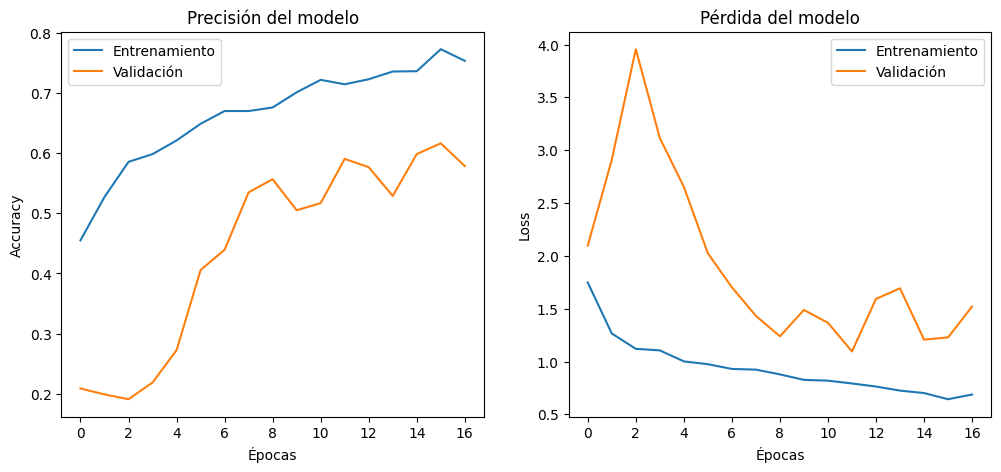

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.5966 - loss: 1.0440

Precisión final en validación: 58.65%


In [48]:
# ============================================
# PARTE 4: EVALUACIÓN Y VISUALIZACIÓN
# ============================================

import matplotlib.pyplot as plt

# Gráficos de precisión y pérdida
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Evaluar en el conjunto de validación
val_loss, val_acc = model.evaluate(val_generator)
print(f"\nPrecisión final en validación: {val_acc:.2%}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step


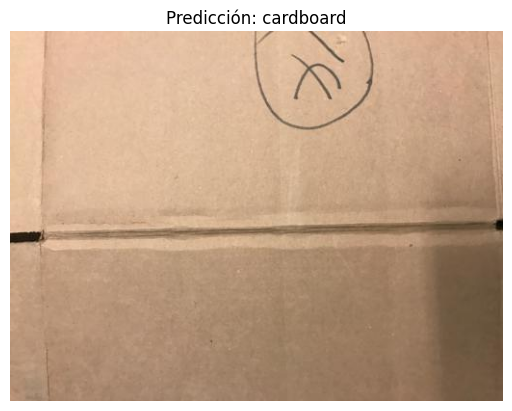

📸 La red neuronal predice que la imagen es: **CARDBOARD**
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


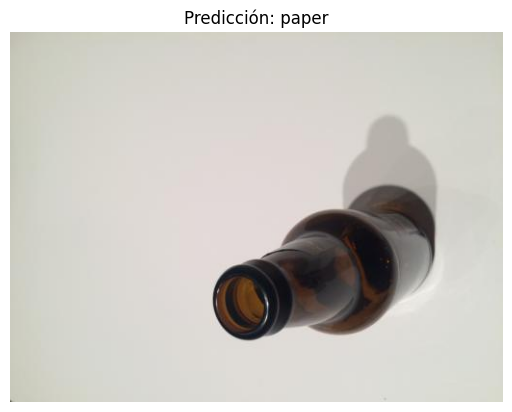

📸 La red neuronal predice que la imagen es: **PAPER**
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


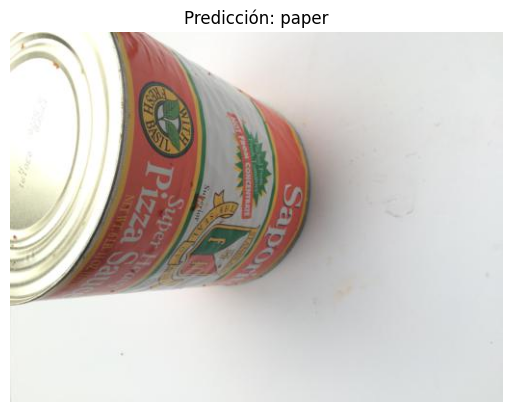

📸 La red neuronal predice que la imagen es: **PAPER**
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


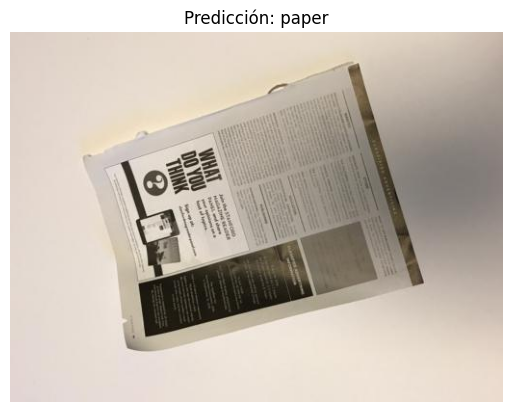

📸 La red neuronal predice que la imagen es: **PAPER**
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


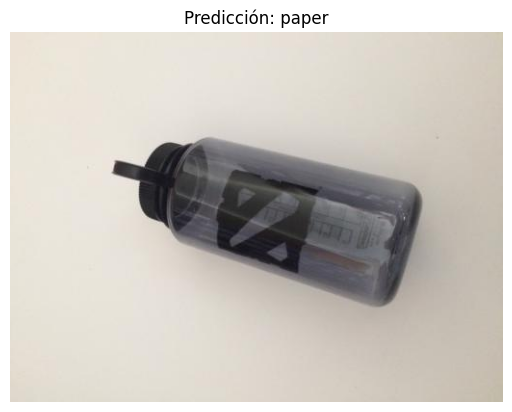

📸 La red neuronal predice que la imagen es: **PAPER**
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


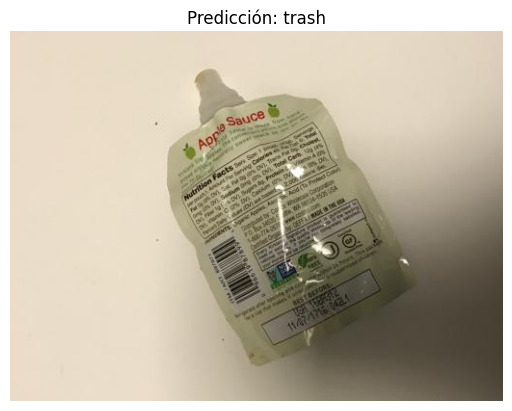

📸 La red neuronal predice que la imagen es: **TRASH**
---


In [49]:
# ============================================
# PARTE 5: PREDICCIÓN CON MÚLTIPLES IMÁGENES
# ============================================

import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os

image_paths = [
    '/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/cardboard/cardboard1.jpg',
    '/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/glass/glass1.jpg',
    '/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/metal/metal1.jpg',
    '/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/paper/paper1.jpg',
    '/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/plastic/plastic1.jpg',
    '/root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1/dataset-resized/trash/trash1.jpg',
]


if not image_paths:
    print("No hay rutas de imágenes en la lista 'image_paths'. Por favor, agrega algunas rutas para realizar predicciones.")
else:
    if 'train_generator' not in globals():
        print("Error: 'train_generator' no está definido. Por favor, ejecuta la celda que crea los generadores de imágenes primero.")
    else:
        for img_path in image_paths:
            if not os.path.exists(img_path):
                print(f"Error: La imagen '{img_path}' no se encontró. Saltando...")
                continue

            try:
                # Cargar y preprocesar la imagen
                img = image.load_img(img_path, target_size=(128, 128))
                img_array = image.img_to_array(img) / 255.0
                img_array = np.expand_dims(img_array, axis=0)  # convertir a batch

                # Realizar predicción
                pred = model.predict(img_array)
                pred_class_index = np.argmax(pred, axis=1)[0]

                # Obtener nombre de la clase
                class_labels = {v: k for k, v in train_generator.class_indices.items()}
                predicted_label = class_labels[pred_class_index]

                # Mostrar resultado
                plt.imshow(image.load_img(img_path))
                plt.axis("off")
                plt.title(f"Predicción: {predicted_label}")
                plt.show()

                print(f"📸 La red neuronal predice que la imagen es: **{predicted_label.upper()}**\n---")

            except Exception as e:
                print(f"Error al procesar la imagen '{img_path}': {e}\n---")

Saving mine_carton.png to mine_carton.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


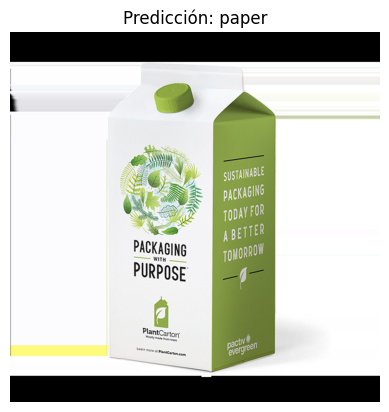

📸 La red neuronal predice que la imagen es: **PAPER**


In [50]:
# ============================================
# PARTE 6: PREDICCIÓN CON IMÁGENES NUEVAS
# ============================================

import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Subir una imagen desde tu computadora
from google.colab import files
uploaded = files.upload()

# Obtener el nombre del archivo subido
img_path = list(uploaded.keys())[0]

# Cargar y preprocesar la imagen
img = image.load_img(img_path, target_size=(128,128))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)  # convertir a batch

# Realizar predicción
pred = model.predict(img_array)
pred_class_index = np.argmax(pred, axis=1)[0]

# Obtener nombre de la clase
class_labels = {v: k for k, v in train_generator.class_indices.items()}
predicted_label = class_labels[pred_class_index]

# Mostrar resultado
plt.imshow(image.load_img(img_path))
plt.axis("off")
plt.title(f"Predicción: {predicted_label}")
plt.show()

print(f"📸 La red neuronal predice que la imagen es: **{predicted_label.upper()}**")


In [51]:
model.save('my_model.keras')

In [53]:
from tensorflow.keras.models import load_model
model = load_model("my_model.keras")


In [54]:
# ============================================
# PARTE 7: TITULO
# ============================================

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a new Sequential model
model_transfer = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compile the new model
model_transfer.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display the summary of the new model
model_transfer.summary()

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_30 (Flatten)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,764,166 (60.14 MB)

 Trainable params: 1,049,478 (4.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [55]:
history_transfer = model_transfer.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25, # Use a reasonable number of epochs for initial training
    callbacks=[early_stop]
)

Epoch 1/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 24s 320ms/step - accuracy: 0.3406 - loss: 1.5959 - val_accuracy: 0.5388 - val_loss: 1.2231
Epoch 2/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 279ms/step - accuracy: 0.6235 - loss: 1.0457 - val_accuracy: 0.5825 - val_loss: 1.1114
Epoch 3/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 238ms/step - accuracy: 0.7057 - loss: 0.8750 - val_accuracy: 0.5825 - val_loss: 1.0921
Epoch 4/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 17s 269ms/step - accuracy: 0.7217 - loss: 0.8127 - val_accuracy: 0.6481 - val_loss: 0.9925
Epoch 5/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 252ms/step - accuracy: 0.7406 - loss: 0.7294 - val_accuracy: 0.6461 - val_loss: 1.0255
Epoch 6/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 28s 437ms/step - accuracy: 0.7614 - loss: 0.7135 - val_accuracy: 0.6362 - val_loss: 0.9883
Epoch 7/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 210ms/step - accuracy: 0.7965 - loss: 0.6292 - val_accuracy: 0.6561 - val_loss: 0.9231
Epoch 8/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 254ms/step - accuracy: 0.7817 - loss: 0.6101 - val_accu

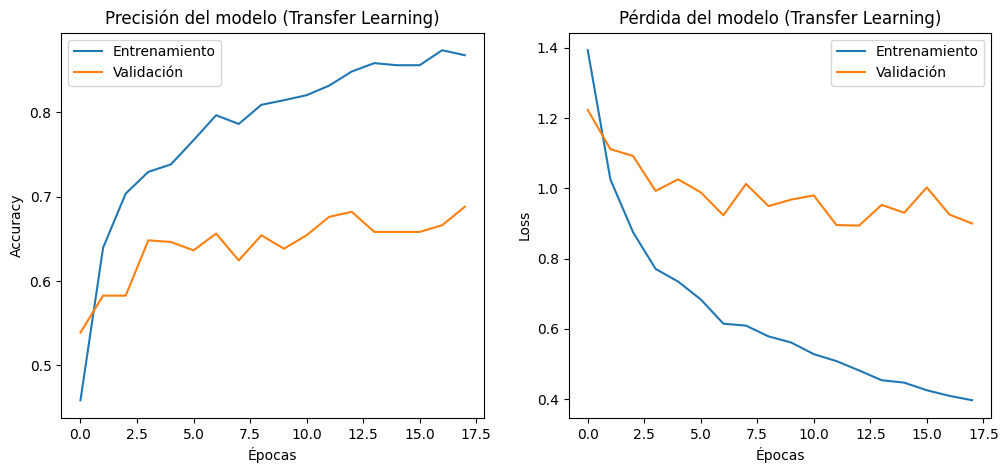

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 213ms/step - accuracy: 0.6744 - loss: 0.8899

Precisión final en validación (Transfer Learning): 66.80%
Pérdida final en validación (Transfer Learning): 0.9091


In [56]:
# ============================================
# PARTE 8: EVALUACIÓN Y VISUALIZACIÓN DEL MODELO DE TRANSFER LEARNING
# ============================================

import matplotlib.pyplot as plt

# Gráficos de precisión y pérdida
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_transfer.history['accuracy'], label='Entrenamiento')
plt.plot(history_transfer.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo (Transfer Learning)')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_transfer.history['loss'], label='Entrenamiento')
plt.plot(history_transfer.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo (Transfer Learning)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Evaluar en el conjunto de validación

if 'val_generator' not in globals():
    print("Error: 'val_generator' no está definido. Por favor, ejecuta la celda que crea los generadores de imágenes primero.")
else:
    val_loss_transfer, val_acc_transfer = model_transfer.evaluate(val_generator)
    print(f"\nPrecisión final en validación (Transfer Learning): {val_acc_transfer:.2%}")
    print(f"Pérdida final en validación (Transfer Learning): {val_loss_transfer:.4f}")

## Ajuste Fino (Fine-tuning)

Ahora realizaremos el ajuste fino. Esto implica descongelar algunas de las capas superiores del modelo base pre-entrenado (VGG16) y entrenarlas junto con las nuevas capas de clasificación que añadimos, pero con una tasa de aprendizaje muy baja.

In [ ]:
# ============================================
# PARTE 9: AJUSTE FINO DEL MODELO DE TRANSFER LEARNING
# ============================================

# Descongelar algunas capas del modelo base para ajuste fino
# Decidimos cuántas capas descongelar desde el final del modelo base.
# VGG16 tiene 19 capas
# no descongelar la primera capa (input layer).
fine_tune_at = 15 # Descongelar a partir de la capa 15 (las últimas 4 capas convolucionales)

# Congelar todas las capas del modelo base inicialmente
for layer in model_transfer.layers[0].layers:
    layer.trainable = False

# Descongelar las capas a partir de 'fine_tune_at'
for layer in model_transfer.layers[0].layers[fine_tune_at:]:
    layer.trainable = True

# Recompilar el modelo con una tasa de aprendizaje más baja
# Una tasa de aprendizaje muy baja es para el ajuste fino
model_transfer.compile(
    optimizer=Adam(learning_rate=0.00001), # Tasa de aprendizaje más baja
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_transfer.summary()

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_30 (Flatten)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,764,166 (60.14 MB)

 Trainable params: 8,128,902 (31.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

## Continuar Entrenamiento con Ajuste Fino

Ahora entrenaremos el modelo nuevamente por algunas épocas adicionales con las capas descongeladas y la tasa de aprendizaje baja.

In [ ]:
# ============================================
# PARTE 10: CONTINUAR ENTRENAMIENTO CON AJUSTE FINO
# ============================================

# Continuar el entrenamiento del modelo con ajuste fino
fine_tune_epochs = 10
total_epochs =  len(history_transfer.history['accuracy']) + fine_tune_epochsr

# early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_fine_tune = model_transfer.fit(
    train_generator,
    validation_data=val_generator,
    epochs=total_epochs,
    initial_epoch=history_transfer.epoch[-1] + 1, # Continuar desde la última época del entrenamiento anterior
    callbacks=[early_stop]
)

# Combinar historiales de entrenamiento para visualización posterior
history_combined = {}
for key in history_transfer.history.keys():
    history_combined[key] = history_transfer.history[key] + history_fine_tune.history[key]

Epoch 19/28
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 281ms/step - accuracy: 0.8527 - loss: 0.4481 - val_accuracy: 0.6461 - val_loss: 1.0351
Epoch 20/28
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 216ms/step - accuracy: 0.8811 - loss: 0.3811 - val_accuracy: 0.6938 - val_loss: 0.9276
Epoch 21/28
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - accuracy: 0.8930 - loss: 0.3173 - val_accuracy: 0.7038 - val_loss: 0.8941
Epoch 22/28
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 213ms/step - accuracy: 0.9140 - loss: 0.2885 - val_accuracy: 0.6958 - val_loss: 0.9335
Epoch 23/28
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - accuracy: 0.9134 - loss: 0.2705 - val_accuracy: 0.7097 - val_loss: 0.9654
Epoch 24/28
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 256ms/step - accuracy: 0.9163 - loss: 0.2483 - val_accuracy: 0.7078 - val_loss: 0.9807
Epoch 25/28
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - accuracy: 0.9395 - loss: 0.1879 - val_accuracy: 0.7296 - val_loss: 0.8942
Epoch 26/28
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 216ms/step - accuracy: 0.9471 - loss: 0.1764 - 

## Evaluación y Visualización después del Ajuste Fino

Después de completar el ajuste fino, evaluaremos el rendimiento del modelo nuevamente y visualizaremos el historial de entrenamiento combinado.

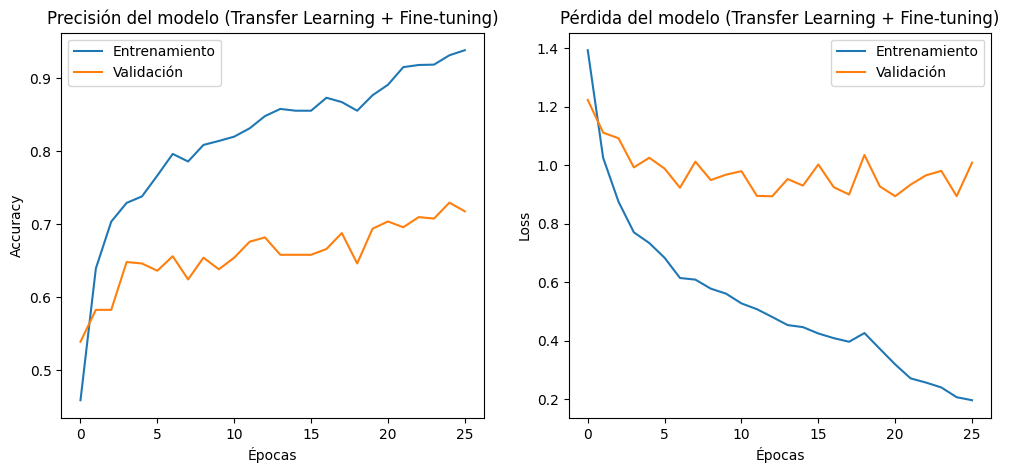

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.6768 - loss: 0.9112

Precisión final en validación (Transfer Learning + Fine-tuning): 67.79%
Pérdida final en validación (Transfer Learning + Fine-tuning): 0.9029


In [ ]:
# ============================================
# PARTE 11: EVALUACIÓN Y VISUALIZACIÓN DESPUÉS DEL AJUSTE FINO
# ============================================

import matplotlib.pyplot as plt

# Gráficos de precisión y pérdida combinados
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_combined['accuracy'], label='Entrenamiento')
plt.plot(history_combined['val_accuracy'], label='Validación')
plt.title('Precisión del modelo (Transfer Learning + Fine-tuning)')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_combined['loss'], label='Entrenamiento')
plt.plot(history_combined['val_loss'], label='Validación')
plt.title('Pérdida del modelo (Transfer Learning + Fine-tuning)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Evaluar en el conjunto de validación
if 'val_generator' not in globals():
    print("Error: 'val_generator' no está definido. Por favor, ejecuta la celda que crea los generadores de imágenes primero.")
else:
    val_loss_fine_tune, val_acc_fine_tune = model_transfer.evaluate(val_generator)
    print(f"\nPrecisión final en validación (Transfer Learning + Fine-tuning): {val_acc_fine_tune:.2%}")
    print(f"Pérdida final en validación (Transfer Learning + Fine-tuning): {val_loss_fine_tune:.4f}")

## Evaluación Final del Mejor Modelo

In [61]:
# Evaluar el mejor modelo en el conjunto de validación
val_loss_best, val_acc_best = best_model.evaluate(val_generator)
print(f"\nPrecisión final en validación (Mejor Modelo): {val_acc_best:.2%}")
print(f"Pérdida final en validación (Mejor Modelo): {val_loss_best:.4f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.7779 - loss: 0.7004

Precisión final en validación (Mejor Modelo): 79.32%
Pérdida final en validación (Mejor Modelo): 0.6758
